In [1]:
# Change the dataset name to to the csv file name in use
dataset_name = "StereoBias"

# Change the model_name to one of the following names
# BERT large    ----> bert-large-uncased
# ALBERT large  ----> albert-xxlarge-v2
# RoBERTa large ----> roberta-large
model_name = "bert-large-uncased"

seed_val = 42

# Change the numbers in random_list for 3 runs of 10-fold cross-validation run
random_list = [42,101,2020]

# Change random_st variable for the 10-fold cross-validation run
random_st = 42

# Hyperparameters
MAX_LEN=64
batch_size = 16
epochs = 10
learning_rate = 1e-5

In [2]:
# Import required libraries
!pip install transformers --quiet
from transformers import *

import random
import pandas as pd
import numpy as np
import os

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score

import pickle
from tqdm import tqdm, trange
import tensorflow as tf

from operator import itemgetter
from statistics import mean, stdev

import seaborn as sns
import matplotlib.pyplot as plt

/data/nlp/aditya/miniforge3/envs/lmharness/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-06 10:55:17.987866: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 10:55:18.007867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738819518.031573   18544 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738819518.038735   18544 cuda_b

In [3]:
# Set the seed value
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [4]:
# Check for GPU device
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:2':
#   raise SystemError('GPU device not found!')
# print('GPU found at: {}'.format(device_name))

In [6]:
# Set the GPU device
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

NVIDIA A100 80GB PCIe


## Hyperbole -> bias
## Metaphor -> Stereotype

In [7]:
# Read the csv data
df = pd.read_csv(dataset_name+'.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df.dropna(axis=0).reset_index(drop=True)

df["bias"] = df["bias"].astype("int")
df["stereotype"] = df["stereotype"].astype("int")

df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'StereoBias.csv'

In [8]:
cols = df.columns
label_cols = list(cols[1:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['Hyperbole', 'Metaphor']


In [9]:
df['one_hot_labels'] = list(df[label_cols].values)
df.head()

,Sentence,Hyperbole,Metaphor,one_hot_labels
0,"Insolent boy, I'll slash you to ribbons!",1,1,"[1, 1]"
1,The level of discombobulation in the realm of ...,1,1,"[1, 1]"
2,His eyes were very dark.,0,0,"[0, 0]"
3,It's been a long time since I found someone ni...,0,0,"[0, 0]"
4,"Oh, you are soaked to the bone, monsieur.",1,1,"[1, 1]"


In [10]:
conditions = [
    (df["Hyperbole"]==0) & (df["Metaphor"]==0),
    (df["Hyperbole"]==0) & (df["Metaphor"]==1),
    (df["Hyperbole"]==1) & (df["Metaphor"]==0),
    (df["Hyperbole"]==1) & (df["Metaphor"]==1)
]
choices = [0,1,2,3]

df["new"] = np.select(conditions, choices)
df.head()

,Sentence,Hyperbole,Metaphor,one_hot_labels,new
0,"Insolent boy, I'll slash you to ribbons!",1,1,"[1, 1]",3
1,The level of discombobulation in the realm of ...,1,1,"[1, 1]",3
2,His eyes were very dark.,0,0,"[0, 0]",0
3,It's been a long time since I found someone ni...,0,0,"[0, 0]",0
4,"Oh, you are soaked to the bone, monsieur.",1,1,"[1, 1]",3


In [11]:
print(df["Metaphor"].value_counts())
print(df["Hyperbole"].value_counts())
print(df.new.value_counts())

y= df["new"].values

0    796
1    622
Name: Metaphor, dtype: int64
1    709
0    709
Name: Hyperbole, dtype: int64
0    602
3    515
2    194
1    107
Name: new, dtype: int64


In [12]:
labels = list(df.one_hot_labels.values)
comments = list(df.Sentence.values)

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True) 

tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_attentions": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/pytorch_model.bin
Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidd

In [14]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for i in range(len(df)):
    tokenizer.padding_side = 'right'
    try:
        encoded_sent = tokenizer.encode_plus(
                            df['Sentence'][i],            # Sentence to encode.
                            add_special_tokens = True, 
                            max_length = MAX_LEN,
                            pad_to_max_length = True
                            )
    except Exception as e:
        print(e)

    input_ids.append(encoded_sent['input_ids'])
    attention_masks.append(encoded_sent['attention_mask'])


print('original: ' , df['Sentence'][100])
print('Token IDs:', input_ids[-1])
print('MASK IDs:', attention_masks[-1])
print(tokenizer.cls_token_id, tokenizer.sep_token_id)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


original:  A day was twenty-four hours long but seemed longer.
Token IDs: [101, 100, 2038, 1037, 2200, 8052, 3716, 2055, 1996, 8605, 5130, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
MASK IDs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
101 102


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [15]:
print("Total number of samples: ", len(input_ids))

Total number of samples:  1418


Run the following cell for 3 runs of 10-fold cross validation

In [17]:
final_list = []
for ran in random_list:
    random_state = ran
    kf = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)

    f1_list = []
    for i,(train_index, validation_index) in enumerate(kf.split(input_ids,y)):
      # if i==2:  
      #   break
      z=i
      print()
      print("---------------------------------FOLD NO: ", i)
      print()
      train_inputs = list(itemgetter(*train_index)(input_ids))
      train_labels = list(itemgetter(*train_index)(labels))
      train_masks = list(itemgetter(*train_index)(attention_masks))

      validation_inputs = list(itemgetter(*validation_index)(input_ids))
      validation_labels = list(itemgetter(*validation_index)(labels))
      validation_masks = list(itemgetter(*validation_index)(attention_masks))

      train_inputs = torch.tensor(train_inputs)
      validation_inputs = torch.tensor(validation_inputs)

      train_labels = torch.tensor(train_labels)
      validation_labels = torch.tensor(validation_labels)

      train_masks = torch.tensor(train_masks)
      validation_masks = torch.tensor(validation_masks)

      train_data = TensorDataset(train_inputs, train_masks, train_labels)
      train_sampler = RandomSampler(train_data)
      train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

      validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
      validation_sampler = SequentialSampler(validation_data)
      validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

      model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, output_attentions=True)
      tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
      model.cuda()

      optimizer = AdamW(model.parameters(),
                        lr = learning_rate,
                        eps = 1e-8
                      )

      train_loss_set = []

      print('len(train_dataloader)', len(train_dataloader))
      total_steps = len(train_dataloader) * epochs
      print('total_steps', total_steps)
      warmup_steps = int(0.06 * total_steps)
      print('warmup_steps', warmup_steps)
     
      scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                  num_warmup_steps = warmup_steps, 
                                                  num_training_steps = total_steps)

      
      for _ in trange(epochs, desc="Epoch"):
        model.train()

        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        # Train the data for one epoch
        for step, batch in enumerate(train_dataloader):
          
          batch = tuple(t.to(device) for t in batch)
         
          b_input_ids, b_input_mask, b_labels = batch
          
          optimizer.zero_grad()

          outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
          logits = outputs[0]
          loss_func = BCEWithLogitsLoss() 
          loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
          train_loss_set.append(loss.item())    

         
          loss.backward()
          optimizer.step()
          scheduler.step()
          
          tr_loss += loss.item()
          nb_tr_examples += b_input_ids.size(0)
          nb_tr_steps += 1

        print("Train loss: {}".format(tr_loss/nb_tr_steps))

      ###############################################################################

        # Validation
        model.eval()

        logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

        for i, batch in enumerate(validation_dataloader):
          batch = tuple(t.to(device) for t in batch)
          b_input_ids, b_input_mask, b_labels = batch
          with torch.no_grad():
            
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()

          tokenized_texts.append(b_input_ids)
          logit_preds.append(b_logit_pred)
          true_labels.append(b_labels)
          pred_labels.append(pred_label)

        pred_labels = [item for sublist in pred_labels for item in sublist]
        true_labels = [item for sublist in true_labels for item in sublist]

        threshold = 0.50
        pred_bools = [pl>threshold for pl in pred_labels]
        true_bools = [tl==1 for tl in true_labels]
        val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
        val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

        print('F1 Validation Accuracy: ', val_f1_accuracy)
        print('Flat Validation Accuracy: ', val_flat_accuracy)

       
      model.eval()

      logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

      for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
         
          outs = model(b_input_ids, attention_mask=b_input_mask)
          b_logit_pred = outs[0]
          pred_label = torch.sigmoid(b_logit_pred)

          b_logit_pred = b_logit_pred.detach().cpu().numpy()
          pred_label = pred_label.to('cpu').numpy()
          b_labels = b_labels.to('cpu').numpy()

        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)

      
      tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
      pred_labels = [item for sublist in pred_labels for item in sublist]
      true_labels = [item for sublist in true_labels for item in sublist]
      
      true_bools = [tl==1 for tl in true_labels]

      pred_bools = [pl>0.50 for pl in pred_labels] 

      # Print and save classification report
      print('Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
      print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
      clf_report = classification_report(true_bools,pred_bools,target_names=label_cols)
  
      print(clf_report)
      f1_list.append(clf_report)

    final_list.extend(f1_list)



---------------------------------FOLD NO:  0



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output

len(train_dataloader) 80
total_steps 800
warmup_steps 48


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.6757181629538536


Epoch:  10%|█         | 1/10 [00:57<08:39, 57.71s/it]

F1 Validation Accuracy:  56.65236051502145
Flat Validation Accuracy:  50.70422535211267
Train loss: 0.5403035182505846


Epoch:  20%|██        | 2/10 [01:54<07:38, 57.35s/it]

F1 Validation Accuracy:  75.4325259515571
Flat Validation Accuracy:  64.08450704225352
Train loss: 0.4188168980181217


Epoch:  30%|███       | 3/10 [02:51<06:40, 57.21s/it]

F1 Validation Accuracy:  78.6206896551724
Flat Validation Accuracy:  67.6056338028169
Train loss: 0.3439780404791236


Epoch:  40%|████      | 4/10 [03:48<05:42, 57.06s/it]

F1 Validation Accuracy:  79.3103448275862
Flat Validation Accuracy:  67.6056338028169
Train loss: 0.28911166498437524


Epoch:  50%|█████     | 5/10 [04:45<04:45, 57.11s/it]

F1 Validation Accuracy:  79.71014492753623
Flat Validation Accuracy:  69.01408450704226
Train loss: 0.254831931181252


Epoch:  60%|██████    | 6/10 [05:42<03:48, 57.04s/it]

F1 Validation Accuracy:  78.65168539325845
Flat Validation Accuracy:  69.71830985915493
Train loss: 0.2174176118336618


Epoch:  70%|███████   | 7/10 [06:39<02:50, 56.96s/it]

F1 Validation Accuracy:  78.81040892193309
Flat Validation Accuracy:  69.01408450704226
Train loss: 0.19466794058680534


Epoch:  80%|████████  | 8/10 [07:36<01:53, 56.94s/it]

F1 Validation Accuracy:  78.94736842105262
Flat Validation Accuracy:  69.71830985915493
Train loss: 0.17672800784930587


Epoch:  90%|█████████ | 9/10 [08:33<00:56, 56.93s/it]

F1 Validation Accuracy:  78.96678966789669
Flat Validation Accuracy:  68.30985915492957
Train loss: 0.1664030622225255


Epoch: 100%|██████████| 10/10 [09:30<00:00, 57.03s/it]

F1 Validation Accuracy:  78.7878787878788
Flat Validation Accuracy:  70.4225352112676


Test F1 Accuracy:  0.787878787878788
Test Flat Accuracy:  0.704225352112676 

              precision    recall  f1-score   support

   Hyperbole       0.83      0.86      0.84        72
    Metaphor       0.76      0.68      0.72        62

   micro avg       0.80      0.78      0.79       134
   macro avg       0.80      0.77      0.78       134
weighted avg       0.80      0.78      0.79       134
 samples avg       0.42      0.43      0.42       134


---------------------------------FOLD NO:  1



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": fa

len(train_dataloader) 80
total_steps 800
warmup_steps 48


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.688147522509098


Epoch:  10%|█         | 1/10 [00:57<08:37, 57.55s/it]

F1 Validation Accuracy:  75.7396449704142
Flat Validation Accuracy:  54.22535211267606
Train loss: 0.5321263313293457


Epoch:  20%|██        | 2/10 [01:54<07:36, 57.05s/it]

F1 Validation Accuracy:  81.4814814814815
Flat Validation Accuracy:  70.4225352112676
Train loss: 0.3950997106730938


Epoch:  30%|███       | 3/10 [02:51<06:38, 56.93s/it]

F1 Validation Accuracy:  81.29496402877699
Flat Validation Accuracy:  69.71830985915493
Train loss: 0.3396463718265295


Epoch:  40%|████      | 4/10 [03:48<05:41, 56.95s/it]

F1 Validation Accuracy:  81.8840579710145
Flat Validation Accuracy:  71.12676056338029
Train loss: 0.29527360536158087


Epoch:  50%|█████     | 5/10 [04:44<04:44, 56.88s/it]

F1 Validation Accuracy:  77.91164658634538
Flat Validation Accuracy:  69.71830985915493
Train loss: 0.270494319871068


Epoch:  60%|██████    | 6/10 [05:41<03:47, 56.93s/it]

F1 Validation Accuracy:  76.11336032388664
Flat Validation Accuracy:  68.30985915492957
Train loss: 0.24305321834981441


Epoch:  70%|███████   | 7/10 [06:38<02:50, 56.90s/it]

F1 Validation Accuracy:  77.16535433070867
Flat Validation Accuracy:  69.71830985915493
Train loss: 0.22248841347172857


Epoch:  80%|████████  | 8/10 [07:35<01:53, 56.86s/it]

F1 Validation Accuracy:  75.60975609756098
Flat Validation Accuracy:  68.30985915492957
Train loss: 0.2108799707144499


Epoch:  90%|█████████ | 9/10 [08:32<00:56, 56.93s/it]

F1 Validation Accuracy:  76.8
Flat Validation Accuracy:  68.30985915492957
Train loss: 0.19848606670275332


Epoch: 100%|██████████| 10/10 [09:29<00:00, 56.94s/it]

F1 Validation Accuracy:  77.10843373493977
Flat Validation Accuracy:  69.01408450704226


Test F1 Accuracy:  0.7710843373493976
Test Flat Accuracy:  0.6901408450704225 

              precision    recall  f1-score   support

   Hyperbole       0.87      0.77      0.82        71
    Metaphor       0.79      0.65      0.71        63

   micro avg       0.83      0.72      0.77       134
   macro avg       0.83      0.71      0.77       134
weighted avg       0.83      0.72      0.77       134
 samples avg       0.38      0.38      0.37       134



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# Collect the results
hp=[]
hr=[]
hf1=[]

mp=[]
mr=[]
mf1=[]

for i in range(len(final_list)):
    temp=final_list[i].split()
    hp.append(float(temp[5]))
    hr.append(float(temp[6]))
    hf1.append(float(temp[7]))
    
    mp.append(float(temp[10]))
    mr.append(float(temp[11]))
    mf1.append(float(temp[12]))

In [22]:
print("Hyperbole Results")
print()
print("Precision",mean(hp))
print("Recall",mean(hr))
print("F1 score",mean(hf1))
print("Std Dev",stdev(hf1))

Hyperbole Results

Precision 0.85
Recall 0.815
F1 score 0.83
Std Dev 0.014142135623730963


In [24]:
print("Metaphor Results")
print()
print("Precision",mean(mp))
print("Recall",mean(mr))
print("F1 score",mean(mf1))
print("Std Dev",stdev(mf1))

Metaphor Results

Precision 0.775
Recall 0.665
F1 score 0.715
Std Dev 0.007071067811865481


Run the following cell to obtain prediction files and models for 10-fold cross validation (single run)

In [26]:
kf = StratifiedKFold(n_splits=10, random_state=random_st, shuffle=True)
f1_list = []
for i,(train_index, validation_index) in enumerate(kf.split(input_ids,y)):
  # if i==1:
  #   break
  z=i
  print()
  print("---------------------------------FOLD NO: ", i)
  print()
  train_inputs = list(itemgetter(*train_index)(input_ids))
  train_labels = list(itemgetter(*train_index)(labels))
  train_masks = list(itemgetter(*train_index)(attention_masks))

  validation_inputs = list(itemgetter(*validation_index)(input_ids))
  validation_labels = list(itemgetter(*validation_index)(labels))
  validation_masks = list(itemgetter(*validation_index)(attention_masks))

  train_inputs = torch.tensor(train_inputs)
  validation_inputs = torch.tensor(validation_inputs)

  train_labels = torch.tensor(train_labels)
  validation_labels = torch.tensor(validation_labels)
  
  train_masks = torch.tensor(train_masks)
  validation_masks = torch.tensor(validation_masks)

  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, output_attentions=True)
  tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
  model.cuda()

  optimizer = AdamW(model.parameters(),
                    lr = learning_rate, 
                    eps = 1e-8 
                  )

  train_loss_set = []
    
  print('len(train_dataloader)', len(train_dataloader))
  total_steps = len(train_dataloader) * epochs
  print('total_steps', total_steps)
  warmup_steps = int(0.06 * total_steps)
  print('warmup_steps', warmup_steps)
 
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = warmup_steps, # Default value in run_glue.py
                                              num_training_steps = total_steps)

  
  for _ in trange(epochs, desc="Epoch"):

    # Training
  
    model.train()
    tr_loss = 0 
    nb_tr_examples, nb_tr_steps = 0, 0
    
    
    for step, batch in enumerate(train_dataloader):
      
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch

      optimizer.zero_grad()

      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = outputs[0]
      loss_func = BCEWithLogitsLoss() 
      loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
      train_loss_set.append(loss.item())    

      
      loss.backward()
      
      optimizer.step()
      scheduler.step()
    
      tr_loss += loss.item()
      nb_tr_examples += b_input_ids.size(0)
      nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

  ###############################################################################

    # Validation

    model.eval()
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    # Predict
    for i, batch in enumerate(validation_dataloader):
      batch = tuple(t.to(device) for t in batch)

      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
      
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

      tokenized_texts.append(b_input_ids)
      logit_preds.append(b_logit_pred)
      true_labels.append(b_labels)
      pred_labels.append(pred_label)

   
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

  
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)

  
  model.eval()

  
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]


  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      
      outs = model(b_input_ids, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)


  tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]
  
  true_bools = [tl==1 for tl in true_labels]

  pred_bools = [pl>0.50 for pl in pred_labels] 

  print('Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
  print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
  clf_report = classification_report(true_bools,pred_bools,target_names=label_cols)
  
  print(clf_report)
  f1_list.append(clf_report)
  
  path_name = dataset_name + "/mtl/" + str(random_st)
  file_path = path_name + "/predictions"+str(z)+ ".csv"
  model_path = path_name + "/model" + str(z)

  if not os.path.exists(path_name):
    os.makedirs(path_name)
  
  val_sent = list(itemgetter(*validation_index)(df.Sentence.values))

  pred_df = pd.DataFrame(list(zip(val_sent, true_bools, pred_bools)), columns=["sentence","true_label","pred_label"])
  pred_df.to_csv(file_path)
  model.save_pretrained(model_path)  
    
  


---------------------------------FOLD NO:  0



loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_attentions": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc4

len(train_dataloader) 80
total_steps 800
warmup_steps 48


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.6972253732383251


Epoch:  10%|█         | 1/10 [00:50<07:38, 50.98s/it]

F1 Validation Accuracy:  71.03448275862068
Flat Validation Accuracy:  57.04225352112676
Train loss: 0.5362343434244394


Epoch:  20%|██        | 2/10 [01:44<06:57, 52.20s/it]

F1 Validation Accuracy:  70.28985507246377
Flat Validation Accuracy:  59.154929577464785
Train loss: 0.4463025700300932


Epoch:  30%|███       | 3/10 [02:38<06:12, 53.24s/it]

F1 Validation Accuracy:  76.05633802816901
Flat Validation Accuracy:  65.49295774647888
Train loss: 0.3744270529597998


Epoch:  40%|████      | 4/10 [03:34<05:25, 54.20s/it]

F1 Validation Accuracy:  75.9581881533101
Flat Validation Accuracy:  65.49295774647888
Train loss: 0.31567469649016855


Epoch:  50%|█████     | 5/10 [04:30<04:34, 54.95s/it]

F1 Validation Accuracy:  74.45255474452556
Flat Validation Accuracy:  63.38028169014085
Train loss: 0.28720657592639326


Epoch:  60%|██████    | 6/10 [05:27<03:42, 55.50s/it]

F1 Validation Accuracy:  73.88059701492537
Flat Validation Accuracy:  63.38028169014085
Train loss: 0.26255414728075266


Epoch:  70%|███████   | 7/10 [06:23<02:47, 55.96s/it]

F1 Validation Accuracy:  75.45787545787545
Flat Validation Accuracy:  65.49295774647888
Train loss: 0.24092725086957217


Epoch:  80%|████████  | 8/10 [07:20<01:52, 56.25s/it]

F1 Validation Accuracy:  76.22641509433961
Flat Validation Accuracy:  67.6056338028169
Train loss: 0.22981519885361196


Epoch:  90%|█████████ | 9/10 [08:17<00:56, 56.45s/it]

F1 Validation Accuracy:  76.33587786259542
Flat Validation Accuracy:  68.30985915492957
Train loss: 0.2146954125724733


Epoch: 100%|██████████| 10/10 [09:14<00:00, 55.45s/it]

F1 Validation Accuracy:  76.8060836501901
Flat Validation Accuracy:  68.30985915492957



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Configuration saved in new_combined/mtl/42/model0/config.json


Test F1 Accuracy:  0.768060836501901
Test Flat Accuracy:  0.6830985915492958 

              precision    recall  f1-score   support

   Hyperbole       0.82      0.82      0.82        72
    Metaphor       0.74      0.68      0.71        62

   micro avg       0.78      0.75      0.77       134
   macro avg       0.78      0.75      0.76       134
weighted avg       0.78      0.75      0.77       134
 samples avg       0.39      0.42      0.40       134



Model weights saved in new_combined/mtl/42/model0/pytorch_model.bin


In [27]:
# Collect the results
hp=[]
hr=[]
hf1=[]

mp=[]
mr=[]
mf1=[]

for i in range(len(f1_list)):
    temp=final_list[i].split()
    hp.append(float(temp[5]))
    hr.append(float(temp[6]))
    hf1.append(float(temp[7]))
    
    mp.append(float(temp[10]))
    mr.append(float(temp[11]))
    mf1.append(float(temp[12]))

In [ ]:
print("Hyperbole Results")
print()
print("Precision",mean(hp))
print("Recall",mean(hr))
print("F1 score",mean(hf1))
print("Std Dev",stdev(hf1))

In [ ]:
print("Metaphor Results")
print()
print("Precision",mean(mp))
print("Recall",mean(mr))
print("F1 score",mean(mf1))
print("Std Dev",stdev(mf1))

Inference on example sentences and attention weights


In [38]:
input_text = "He went a thousand miles to be here."


inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
model = AutoModelForSequenceClassification.from_pretrained(path_name + "/model0", output_attentions=True) 
model.cuda()
outputs = model(inputs.to(device))  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings

loading configuration file new_combined/mtl/42/model0/config.json
Model config BertConfig {
  "_name_or_path": "new_combined/mtl/42/model0",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_attentions": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file new_combined/mtl/42/model0/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceCla

In [39]:
sum = torch.zeros(len(tokens),len(tokens))
for i in range(16):
    if i==0:
        sum=outputs[-1][-1][0][i]
    sum = torch.add(sum,outputs[-1][-1][0][i])
#     outputs[-1][-1][0][0]
sum[0]/torch.sum(sum[0])

tensor([0.1706, 0.0204, 0.0719, 0.2325, 0.0764, 0.0478, 0.0261, 0.0315, 0.0291,
        0.2276, 0.0661], device='cuda:0', grad_fn=<DivBackward0>)

In [40]:
new_tokens=[]
a = torch.mean(outputs[-1][-1][:,:,0,:],1)[0][1:-1]
for t in tokens:
    new_tokens.append(tokenizer.convert_tokens_to_string(t))
inf_df = pd.DataFrame([(a/torch.sum(a)).tolist()], columns=new_tokens[1:-1])
inf_df

,[ U N K ],w e n t,a,t h o u s a n d,m i l e s,t o,b e,h e r e,.
0,0.028354,0.100813,0.284534,0.107489,0.066532,0.036349,0.044139,0.040933,0.290856


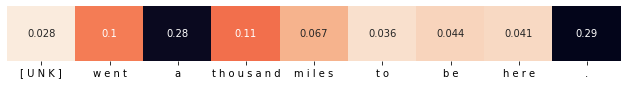

In [41]:
fig, ax = plt.subplots(figsize=(len(tokens), 1))
sns.heatmap(inf_df,cmap=sns.cm.rocket_r, cbar=False, annot=True, yticklabels=False)
plt.show()